<a href="https://colab.research.google.com/github/AlexanderNeuwirth/CS5265_Project1/blob/main/CS5265_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 Definition
Created for CS5265 at Vanderbilt University

## Background

How much can be inferred about a product's nutritional attributes from what you can easily see on the product listing?

In other words, can you predict nutritional factors from brand, serving size, key words in the product title, and common ingredients?

This type of problem is of particular interest in a healthcare setting, where understanding a product in context of its nutritional components is necessary to make food purchasing decisions that are safe for specific medical needs. I often use similar data in my day-to-day work on healthcare procurement systems. It's interesting and potentially useful to explore possible relationships between different products, ingredients, and brands, and their corresponding nutritional features.

Due to wide available of government datasets and recipe sites with easily scraped online datasets, a fair amount of work has been done in this area. 

Random forest has been successfully applied to [predict processed vs unprocessed food](https://www.medrxiv.org/content/10.1101/2021.05.22.21257615v2.full), primarily from ingredient lists.

In Norway, large amounts of missing data in government databases led at least one group to attempt nutrition extraction [purely from natural language product descriptions](https://static1.squarespace.com/static/606f36b890215d7048ddaac0/t/62ed22f1ad65d913278ca3cb/1659708147387/PREDICTING+A+FOOD+PRODUCT%E2%80%99S+MISSING+NUTRITIONAL+VALUES+USING+MACHINE+LEARNING.pdf). Their method suffers in cases with poor quality descriptions, and has no mechanism to weight by token importance, but outperforms simple imputation methods.

Even nutrition prediction from raw images has seen [some success](https://arxiv.org/pdf/2011.01082.pdf?from=article_link), with confirmation by at least one [subsquent review experiment](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8787663/) that prepared new samples with known nutrition details.

No published method seems to approach this problem using simple feature engineering on the description and ingredient list, seeking to predict nutrient attributes. That is the gap I seek to investigate in this work.

## Project Description

This project will attempt to perform binary classification on whether products meet a "low fat" dietary classification using only those higher-level features like brand, serving size, key words in the product title, and common ingredients.

This project uses the [USDA Branded Food Products Dataset](https://data.nal.usda.gov/dataset/usda-branded-food-products-database). This data contains detailed ingredient listings, serving amounts, and nutrient quantities for about 250,000 branded and private-label food products sold in the United States. All entries are laboratory results with thorough human review and are held to high data quality standards by law, as the precise values inform many clinical and regulatory policy enforcement.

Some raw data fields include:
* **Product Title**: A text description
* **Serving Size**: Continuous-valued numerical usage quantity (normalized to either grams or milliliters)
* **Nutritionals**: Continuous-valued numerical nutrient quantities (by weight)
* **Ingredients**: A comma-separated list of ingredients (as strings)

Some easily derived processed data fields could include:
* **Total Calories**: by summing simple benchmark multipliers of carbs, proteins, and fats
* **Low Fat**: by thresholding fat total against the conventional threshold of 3 grams per serving
* **Binary "Contains Ingredient" Features**: by filtering on the presence of common ingredient strings in the string ingredient column

If successful in this task and similar binary classification tasks of interest, it may be appropriate to attempt regression on more complex target variables (like calorie count, grams of fat, or grams of fiber).

Example Input Features:
* Serving size (continuous)
* Brand (categorical)
* Key terms extracted from description (e.g. "Healthy", "Diet", "Organic") (binary)
* Presence of specific ingredient terms, extracted from ingredient list (e.g. "Butter", "Corn Syrup", "Sugar"

Example Output Features:
* Low-Fat (binary classification)
* *(Aspirational)* Calorie count (integer regression)

## Performance Metric
For the initial goal of binary low-fat classification, an appropriate performance metric is simple percent accuracy.
If accuracy is low, precision and recall will be useful metrics to determine any bias in the error. If classes are heavily unbalanced (e.g. there are relatively few low-fat products) it may be appropriate to use an accuracy metric that reflects both precision and recall, like F1 score.

Mathematical formulations of all of the above metrics are provided below, where T and F stand for "True" and "False", and P and N stand for "Positive" and "Negative."

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$
$$Precision = \frac{TP}{TP+FP}$$
$$Recall = \frac{TP}{TP+FN}$$
$$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$$


For the stretch goal of calorie count regression, an appropriate performance metric may be mean absolute error (MAE). (Given below where x is the actual value, y is the predicted value, and D is the number of data points being evaluated.)

$$\sum_{i=1}^{D}|x_i-y_i|$$

This would be easily interpretable as how far off the model's predictions are from the actual number of calories (as opposed to mean squared error, which would be less readily interpretable.)

## Basic EDA
Key questions:

1. Are full macronutrient details available for each product in the data? If not, what % of coverage do we have?
2. Are units standardized for both servings and nutrients? If not, how difficult will standardization be?
3. How much diversity of manufacturer/brand types exists in the data? Including count, frequent terms, and general recognizability of names in a random sample.
4. What range of serving sizes exists in the data? What are the extreme outliers?

### Google Drive Connection

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/MyDrive/food_nutrition_data/

Mounted at /content/drive
BFPD_Doc.pdf			 Nutrients.csv	Serving_size.csv
Derivation_Code_Description.csv  Products.csv


### Data Loading

In [2]:
import pandas as pd

products_df = pd.read_csv("drive/MyDrive/food_nutrition_data/Products.csv", low_memory=False)
nutrients_df = pd.read_csv("drive/MyDrive/food_nutrition_data/Nutrients.csv", low_memory=False)
servings_df = pd.read_csv("drive/MyDrive/food_nutrition_data/Serving_size.csv", low_memory=False)

### Nutrient Joining

In [3]:
coverage = products_df.NDB_Number.isin(nutrients_df.NDB_No).value_counts()
print(f"{round(coverage[1]*100/coverage.sum(), 2)}% of products have some nutrient info")

99.48% of products have some nutrient info


In [4]:
# Verify that each nutrient code corresponds to a unique name
print(nutrients_df.groupby("Nutrient_Code").Nutrient_name.nunique().value_counts())

1    95
Name: Nutrient_name, dtype: int64


In [5]:
# Find nutrients that appear at least ~10% of the time
occurence_counts = nutrients_df.Nutrient_name.value_counts()
occurence_counts[(occurence_counts > nutrients_df.NDB_No.nunique() * 0.1)]

Carbohydrate, by difference           237635
Total lipid (fat)                     237559
Protein                               237432
Sodium, Na                            236887
Energy                                228500
Sugars, total                         223394
Fatty acids, total saturated          205694
Cholesterol                           202966
Fiber, total dietary                  198171
Iron, Fe                              196981
Calcium, Ca                           196065
Fatty acids, total trans              194801
Vitamin C, total ascorbic acid        178809
Vitamin A, IU                         174501
Potassium, K                           53337
Fatty acids, total monounsaturated     33822
Fatty acids, total polyunsaturated     33799
Vitamin D                              27668
Name: Nutrient_name, dtype: int64

In [6]:
# Drop nutrients that don't occur that often. These seem to be manually entered, and many apply to only a handful of products
nutrients_to_drop = occurence_counts[(occurence_counts < nutrients_df.NDB_No.nunique() * 0.1)].index
nutrients_df = nutrients_df[~nutrients_df.Nutrient_name.isin(nutrients_to_drop)]

In [7]:
# Verify that we don't need to normalize output UOMs since they are consistent for a given nutrient (no mixing mg and g)
print(f"Maximium unique units of measure per nutrient: {nutrients_df.groupby('Nutrient_name').Output_uom.nunique().max()}")

Maximium unique units of measure per nutrient: 1


In [8]:
# Roll up nutrients df of product-nutrient pairs into nutrient feature columns
nutrients_pivot = nutrients_df.pivot_table(values='Output_value', index=nutrients_df['NDB_No'], columns='Nutrient_name', aggfunc='first')
nutrients_pivot.head()

Nutrient_name,"Calcium, Ca","Carbohydrate, by difference",Cholesterol,Energy,"Fatty acids, total monounsaturated","Fatty acids, total polyunsaturated","Fatty acids, total saturated","Fatty acids, total trans","Fiber, total dietary","Iron, Fe","Potassium, K",Protein,"Sodium, Na","Sugars, total",Total lipid (fat),"Vitamin A, IU","Vitamin C, total ascorbic acid",Vitamin D
NDB_No,,,,,,,,,,,,,,,,,,
45001524,50.0,35.00,25.0,200.0,NaN,NaN,3.75,0.0,0.0,0.0,NaN,2.5,75.0,30.00,6.25,0.0,3.0,NaN
45001528,0.0,43.24,0.0,162.0,NaN,NaN,0.00,0.0,0.0,0.0,NaN,0.0,703.0,37.84,0.00,270.0,9.7,NaN
45001529,0.0,41.18,0.0,176.0,NaN,NaN,0.00,0.0,0.0,0.0,NaN,0.0,676.0,35.29,0.00,0.0,0.0,NaN
45001530,0.0,34.29,0.0,143.0,NaN,NaN,0.00,0.0,0.0,0.0,NaN,0.0,971.0,28.57,0.00,0.0,0.0,NaN
45001531,0.0,45.95,0.0,189.0,NaN,NaN,0.00,0.0,0.0,0.0,NaN,0.0,757.0,43.24,0.00,0.0,0.0,NaN


In [9]:
# Merge nutrient columns to original product data
df = pd.merge(products_df, nutrients_pivot, left_on="NDB_Number", right_on="NDB_No", how="left")

### Serving Size Joining

In [10]:
# Verify servings lines are unique (we don't need to deal with conflicts, etc)
print(f"Max unique serving definitions per product: " +
      f"{servings_df.NDB_No.value_counts().max()}")

Max unique serving definitions per product: 1


In [11]:
df = pd.merge(df, servings_df, left_on="NDB_Number", right_on="NDB_No", how="left")

In [12]:
df.head()

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,"Calcium, Ca","Carbohydrate, by difference",...,Total lipid (fat),"Vitamin A, IU","Vitamin C, total ascorbic acid",Vitamin D,NDB_No,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State
0,45001524,MOCHI ICE CREAM BONBONS,LI,019022128593,"G. T. Japan, Inc.",2017-11-15 19:19:38,2017-11-15 19:19:38,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STR...",50.0,35.00,...,6.25,0.0,3.0,NaN,45001524.0,40.0,g,1.0,PIECE,NaN
1,45001528,CHIPOTLE BARBECUE SAUCE,LI,5051379043735,FRESH & EASY,2018-04-26 17:23:31,2018-04-26 17:23:31,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLE...",0.0,43.24,...,0.00,270.0,9.7,NaN,45001528.0,37.0,g,2.0,Tbsp,NaN
2,45001529,HOT & SPICY BARBECUE SAUCE,LI,5051379009434,FRESH & EASY,2018-04-26 18:17:37,2018-04-26 18:17:37,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE,...",0.0,41.18,...,0.00,0.0,0.0,NaN,45001529.0,34.0,g,2.0,Tbsp,NaN
3,45001530,BARBECUE SAUCE,LI,5051379019969,FRESH & EASY,2018-04-26 17:24:00,2018-04-26 17:24:00,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DIS...",0.0,34.29,...,0.00,0.0,0.0,NaN,45001530.0,35.0,g,2.0,Tbsp,NaN
4,45001531,BARBECUE SAUCE,LI,5051379009526,FRESH & EASY,2018-04-26 17:47:41,2018-04-26 17:47:41,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE,...",0.0,45.95,...,0.00,0.0,0.0,NaN,45001531.0,37.0,g,2.0,Tbsp,NaN


### EDA Question 1: Missing Macronutrients

In [13]:
missing_fat = df["Total lipid (fat)"].isna()
missing_protein = df["Protein"].isna()
missing_carbs = df["Carbohydrate, by difference"].isna()

In [14]:
# Confirming that "0" data points exist - the NAs likely account for actual
# missing data, not "fat free" data
(df["Total lipid (fat)"] == 0).sum()

75947

In [15]:
def format_percent(s):
  return (f"{round((s.sum()*100)/len(df), 2)}%")

print(f'{format_percent(missing_fat)} are missing fat data')
print(f'{format_percent(missing_protein)} are missing protein data')
print(f'{format_percent(missing_carbs)} are missing carbs data')

print(f'{format_percent((missing_fat | missing_protein | missing_carbs))} are missing at least one type')
print(f'{format_percent((missing_fat & missing_protein & missing_carbs))} are missing all types')

0.64% are missing fat data
0.69% are missing protein data
0.61% are missing carbs data
0.83% are missing at least one type
0.54% are missing all types


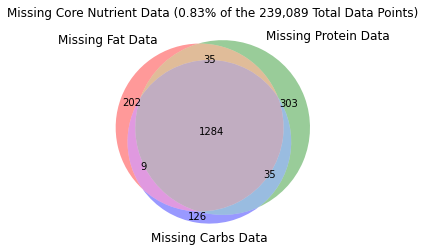

In [16]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

set1 = set(df[missing_fat].index)
set2 = set(df[missing_protein].index)
set3 = set(df[missing_carbs].index)

venn3([set1, set2, set3], ('Missing Fat Data', 'Missing Protein Data', 'Missing Carbs Data'))
plt.title("Missing Core Nutrient Data (0.83% of the 239,089 Total Data Points)")
plt.show()

### EDA Question 2: Unit Standardization

In [17]:
# We actually already needed to investigate this when joining the nutrient data,
# to make sure it was appropriate to roll up the values into columns without
# normalizing into units of measure.
print(f"Maximium unique units of measure per nutrient: " +
      f"{nutrients_df.groupby('Nutrient_name').Output_uom.nunique().max()}")

Maximium unique units of measure per nutrient: 1


Text(0, 0.5, 'Total Occurences')

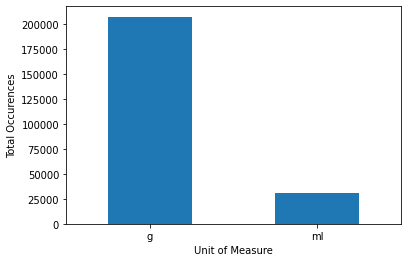

In [18]:
# Now to check if servings are standardized..
df.Serving_Size_UOM.value_counts().plot(kind="bar")
plt.xticks(rotation=0)
plt.xlabel("Unit of Measure")
plt.ylabel("Total Occurences")

In [19]:
percent_grams = round(df.Serving_Size_UOM.value_counts()[0]/df.Serving_Size_UOM.count()*100, 2)
print(f"{percent_grams}% of products have serving size in grams")

87.0% of products have serving size in grams


In [20]:
# Let's look at a sample of products in ml to see if we can use the density
# of water as a good approximation to convert them to grams...
df[df.Serving_Size_UOM == "ml"].long_name.sample(25)

153369                       PREMIUM JUICE FROM CONCENTRATE
237375                                    MAINE MAPLE SYRUP
236011                                            ROOT BEER
142679                                           GINGER ALE
69671                                           AGUA FRESCA
110887                                                SYRUP
59010                SHASTA, CAFFEINE FREE SODA, TIKI PUNCH
142084                          ZERGUT, VINEGAR, WHITE WINE
143829                 EXTRA VIRGIN OLIVE OIL FOR BEEF/LAMB
143641    ORGANIC ACAI JUICE BEVERAGE BLEND WITH POMEGRA...
85099           OKF, ALOE VERA KING, ALOE VERA DRINK, MANGO
170808                                             DRESSING
71817     FRUIT IN ITS BIRTHDAY SUIT, ORGANIC HONEY CRIS...
180299                                 RANCH DIP 7 DRESSING
204377                               CHILLERS CITRUS PUNCH 
143475                          100% ITALIAN PURE OLIVE OIL
231015          Mountain Dew Baja Blast 

Water has a density of 1 g/ml

Based on web searches:
* Whole milk has a density of about 1.04 g/ml
* Eggnog has a density of about 1.07 g/ml
* Salsa has a density of about 1.2 g/ml
* Honey has a density of about 1.3 g/ml
* Oil has a density of about 0.7 g/ml

I was unable to find anything more extreme than these examples in any of several searches, so we could assume a 1 ml = 1 g conversion with only about 30% error in most reasonable cases

### EDA Question 3: Diversity of Manufacturer/Brand Types

In [21]:
# Random sample to get a sense of typical values.
# Many organizations are instantly recognizable.
df.manufacturer.sample(25)

215803                           KIND Inc.
187840                   Tyson Foods, Inc.
134246                Borden Dairy Company
113890                              BRICKS
90741                       Oregon Harvest
185149                 SWEET P'S BAKE SHOP
213123           Sabra Dipping Company LLC
26681                     Star Markets Co.
19326            Atkins Nutritionals, Inc.
35276                 Indulgent Foods, LLC
101145                             SPARTAN
180621                     B&G Foods, Inc.
32975             Whole Foods Market, Inc.
161414         Wismettac Asian Foods, Inc.
70404     Dansk Cookie Industri A/S Kelsen
143233        Georgia Peach Products, Inc.
22336                We The Pie People LLC
66292                       7-Eleven, Inc.
39278                       The Kroger Co.
142408                  Weis Markets, Inc.
71544                   NOT A BRANDED ITEM
55266                   Kellogg Company US
16176                       The Kroger Co.
899        

In [22]:
# The top manufacturers: all big-label retail food grocers (Wal-Mart, Meijer, Kroger),
# manufacturers/distributors (General Mills, Supervalu), and GPOs (Topco)
df.manufacturer.value_counts().head(10)

Wal-Mart Stores, Inc.       4546
Meijer, Inc.                3855
Target Stores               3771
The Kroger Co.              3476
Safeway, Inc.               3194
Topco Associates, Inc.      2905
Supervalu, Inc.             2771
Hy-Vee, Inc.                2667
Weis Markets, Inc.          2207
GENERAL MILLS SALES INC.    1966
Name: manufacturer, dtype: int64

In [23]:
# normalize case and remove special characters
clean_manufacturer_names = df.manufacturer.str.replace("[^a-zA-Z ]", "", regex=True).str.lower()
# collapse multiple spaces
clean_manufacturer_names = clean_manufacturer_names.str.replace("\s+", " ", regex=True)
# split into token lists
clean_manufacturer_tokens = clean_manufacturer_names.str.split(' ', expand=True).stack()

In [24]:
clean_manufacturer_tokens.value_counts().head(10)

inc        106187
foods       28118
company     22667
llc         18818
co          14268
stores      12276
the         11544
food        10304
markets      8630
usa          6791
dtype: int64

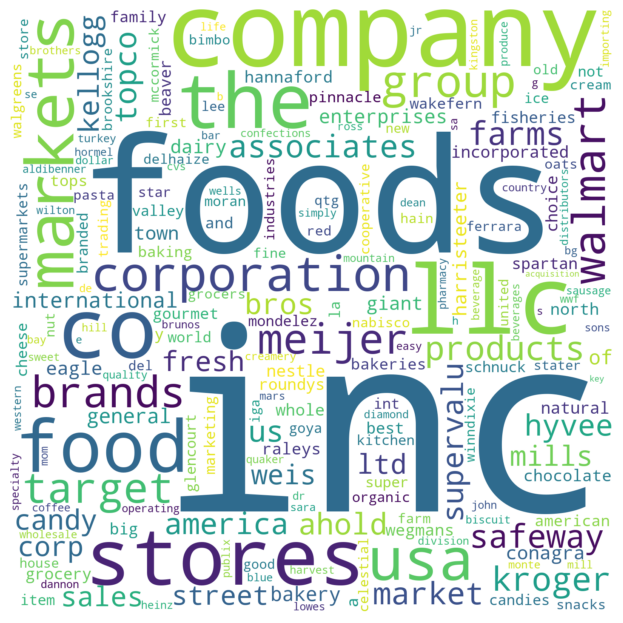

In [25]:
from wordcloud import WordCloud
wordcloud = WordCloud(
    width = 1600, height = 1600, background_color ='white', min_font_size = 10)
wordcloud.generate_from_frequencies(clean_manufacturer_tokens.value_counts())
fig=plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### EDA Question 4: Serving Size Range and Outliers

count    206950.000000
mean         61.227138
std          58.474537
min           0.015000
25%          28.000000
50%          40.000000
75%          85.000000
max        2808.000000
Name: Serving_Size, dtype: float64

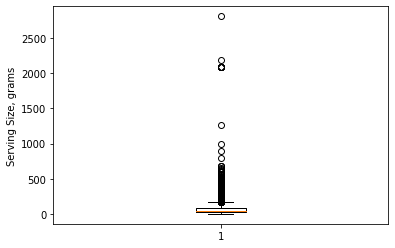

In [26]:
# Boxplot: By-weight products
g_sizes = df[df.Serving_Size_UOM == 'g'].Serving_Size.dropna()
plt.boxplot(g_sizes)
plt.ylabel("Serving Size, grams")

# Simple summary stats
g_sizes.describe()

count    30925.000000
mean       202.599058
std        141.815038
min          0.120000
25%         30.000000
50%        240.000000
75%        240.000000
max       3750.000000
Name: Serving_Size, dtype: float64

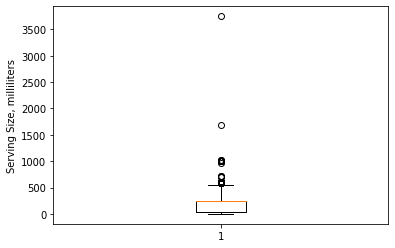

In [27]:
# Boxplot: By-volume products
ml_sizes = df[df.Serving_Size_UOM == 'ml'].Serving_Size.dropna()
plt.boxplot(ml_sizes)
plt.ylabel("Serving Size, milliliters")

# Simple summary stats
ml_sizes.describe()

In [28]:
# Largest serving sizes
df.sort_values("Serving_Size", ascending=False).head(15)

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,"Calcium, Ca","Carbohydrate, by difference",...,Total lipid (fat),"Vitamin A, IU","Vitamin C, total ascorbic acid",Vitamin D,NDB_No,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State
200374,45330005,ORGANIC CHOPPED TOMATOES,LI,677294998186,ORGANICO BELLO,2017-10-13 18:14:18,2017-10-13 18:14:18,"ORGANIC CHOPPED TOMATOES, ORGANIC TOMATO PUREE.",1.0,0.19,...,0.00,NaN,0.4,0.0,45330005.0,3750.0,ml,0.50,cup,NaN
56039,45133744,ACT II Butter Lovers Popcorn,GDSN,00076150232530,ConAgra Foods Inc.,2018-02-12 15:49:47,2018-04-26 10:20:47,"Popping Corn, Palm Oil, Salt, Less than 2% of:...",0.0,0.68,...,0.14,0.0,0.0,NaN,45133744.0,2808.0,g,2.00,tbsp (30g) unpopped (makes about 4.5 cups popped),UNPREPARED
55598,45130180,ACT II Butter Lovers Popcorn,GDSN,00076150232547,ConAgra Foods Inc.,2017-11-30 14:43:32,2018-04-26 10:20:47,"Popping Corn, Palm Oil, Salt, Less than 2% of:...",0.0,0.87,...,0.18,0.0,0.0,NaN,45130180.0,2184.0,g,2.00,tbsp (30g) unpopped (makes about 4.5 cups popped),UNPREPARED
99287,45187513,"SWEET ACTION, ICE CREAM, VEGAN STRAWBERRY",LI,751570510498,Sculatti I.F.S.,2017-07-14 18:37:31,2017-07-14 18:37:31,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",3.0,1.82,...,0.57,5.0,0.7,NaN,45187513.0,2091.0,g,4.00,ONZ,NaN
99288,45187514,"SWEET ACTION ICE CREAM, ICE CREAM, VEGAN COCON...",LI,751570510511,Sculatti I.F.S.,2017-07-14 18:37:31,2017-07-14 18:37:31,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",4.0,1.82,...,0.77,5.0,0.1,NaN,45187514.0,2091.0,g,4.00,ONZ,NaN
83685,45169021,"SWEET ACTION ICE CREAM, ICE CREAM, VEGAN COFFE...",LI,751570510467,Sculatti I.F.S.,2017-07-14 18:01:22,2017-07-14 18:01:22,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",3.0,1.82,...,0.67,5.0,0.1,NaN,45169021.0,2091.0,g,4.00,ONZ,NaN
99157,45187353,"SWEET ACTION, ICE CREAM, VEGAN MINT CHIP",LI,700621453444,Disk Technologies Corporation,2018-01-20 03:51:49,2018-01-20 03:51:49,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",3.0,1.87,...,0.77,24.0,0.1,NaN,45187353.0,2091.0,g,4.00,ONZ,NaN
83745,45169100,"SWEET ACTION, ICE CREAM, VEGAN CINNAMON ROLL",LI,799491898615,Reese Orchards,2017-07-14 18:01:51,2017-07-14 18:01:51,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",4.0,2.58,...,0.81,5.0,0.1,NaN,45169100.0,2091.0,g,4.00,ONZ,NaN
99286,45187512,"SWEET ACTION, ICE CREAM, VEGAN COOKIES + CREAM",LI,751570510474,Sculatti I.F.S.,2017-10-31 14:57:51,2017-10-31 14:57:51,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",3.0,1.87,...,0.72,5.0,0.1,NaN,45187512.0,2091.0,g,4.00,ONZ,NaN
83509,45168774,"SWEET ACTION, ICE CREAM, VANILLA BEAN",LI,700621453383,Disk Technologies Corporation,2017-07-14 18:00:41,2017-07-14 18:00:41,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",3.0,1.63,...,0.67,5.0,0.1,NaN,45168774.0,2091.0,g,4.00,ONZ,NaN


There is clearly some bad data at the top. Careful analysis indicates that these are the result of calculation errors:
1. Popcorn: the entries indicate that 2 tbsp of kernels yield over 2 kilograms of popped corn. This seems to be the result of a bad volume-to-weight conversion. My attempt to replicate their bad calculation leads to a similar value to the one they achieve, within about 30%.
2. Vegan ice cream: the serving size seems to be the result of a bad conversion of the "ONZ" label into weight. Either ONZ means something other than ounces in this context, or the volume of the container is not fully taken up with the product.
3. There are some other high-serving products (potatoes, etc) that seem to have been incorrectly manually converted. For example: the imperial to metric conversion is off by about a factor of ten

After these few bad data points, the data is dominated by reasonable high-volume liquids like bottled water and baby formula.

In [29]:
# Smallest serving sizes
df.sort_values("Serving_Size", ascending=True).head(5)

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,"Calcium, Ca","Carbohydrate, by difference",...,Total lipid (fat),"Vitamin A, IU","Vitamin C, total ascorbic acid",Vitamin D,NDB_No,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State
177031,45283500,NO CALORIE SWEETENER TABLETS,LI,722776001448,SPLENDA,2018-01-19 21:51:00,2018-01-19 21:51:00,"LACTOSE (FROM MILK), SUCRALOSE, CROSCARMELLOSE...",NaN,0.0,...,0.0,NaN,NaN,NaN,45283500.0,0.015,g,1.0000,TABLET,NaN
27872,45060333,SAFFRON THREADS,LI,016291441491,Morton Bassett Inc.,2017-07-27 03:37:35,2017-07-27 03:37:35,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,45060333.0,0.025,g,0.1250,tsp,NaN
83666,45168991,"NUNATURALS, LOSWEET PREMIUM NATURAL SWEETNER",LI,739223001876,"Nunaturals, Inc.",2018-04-11 07:08:02,2018-04-11 07:08:02,LO HAN GUO (MONK FRUIT) EXTRACT.,NaN,0.0,...,0.0,NaN,NaN,NaN,45168991.0,0.035,g,0.0150,tsp,NaN
99262,45187482,NUSTEVIA REB99 PREMIUM NATURAL SWEETENER,LI,739223006000,"Nunaturals, Inc.",2017-07-14 18:37:23,2017-07-14 18:37:23,STEVIA EXTRACT (STEVIA REBAUDIANA) (LEAF).,NaN,0.0,...,0.0,NaN,NaN,NaN,45187482.0,0.035,g,0.0156,tsp,NaN
163168,45268188,STEVIA SWEETENER TABLETS,LI,716123128407,"United American Industries,Inc",2018-01-31 18:01:47,2018-01-31 18:01:47,"CELLULOSE, ORGANIC STEVIA LEAF EXTRACT, SILICA",NaN,0.0,...,0.0,NaN,NaN,NaN,45268188.0,0.043,g,1.0000,TABLET (EQUAL TO 100 TSP. OF SUGAR),NaN


The extreme lows seem rather unremarkable: sweeteners, seasonings, etc., that would be expected to have an extremely low serving size.

In [30]:
# Sample of typical serving sizes
df[["long_name", "Serving_Size", "Serving_Size_UOM"]].sample(10)

,long_name,Serving_Size,Serving_Size_UOM
19370,"EMMA, PRESERVES, RASPBERRY",20.0,g
230377,NABISCO CHIPS AHOY! COOKIES BIG COOKIE BLONDE ...,32.0,g
60796,"AHOLD, INSTANT OATMEAL, CRANBERRY, PECAN & VAN...",35.0,g
231209,GAMESA SUGAR WAFER STRAWBERRY 6.7 /12,34.0,g
180532,APPLE SAUCE,113.0,g
129325,DICED TOMATOES,123.0,g
65824,"SUN HARVEST, SIMPLY CHOCOLATY CHIP COOKIES",28.0,g
165082,SUGAR BOWTIES,28.0,g
68091,"FERRIS, FANCY MIXED NUT",28.0,g
184411,CHOPPED KALE GREENS,128.0,g


These all seem reasonable, with a rough benchmark of 1 gram per potato chip for reference.

### EDA Answer Summary
1. Missing Macronutrients: About 99.2% of the data has complete macronutrients. For simplicity, we will likely discard the remainder of the data, since it seems likely to be incomplete or inaccurate in other ways too.
2. Unit Standardization: Nutrient information is completely standardized already. Serving size units are standardized by either weight or volume. The majority of the data (87%) is expressed by weight. We could discard the by-volume data: however, intuition and a careful analysis of the liquid data indicates that approximating 1 ml = 1 gram would be appropriate for most products, since food priced by volume is typically water, syrup, or oil based. An analysis of several such products, including extreme examples like cream, salsa, honey and oil, all fell within about 30% of a 1 g/ml density, likely close enough to proceed with assuming this conversion.
3. Diversity of Manufacturer/Brand Types: The main contributers to the dataset are from US national food retailers (like Walmart and Kroger), food GPOs, and major manufacturers. There seems to be a long tail of smaller brands and manufacturers: additionally, some larger manufacturers seem to be obfuscating their contributions (intentionally or otherwise) by using subbrand names or adding random numbers to their brand names.
4. Serving size range and outliers: The data ranges between reasonable extremes of food servings: from sub-0.1-gram servings of seasonings and sweeteners to 1-liter servings of water and baby formula. There are a couple obviously bad data points at the extreme high end, with possible explanations enumerated within the analysis above. A cursory overview of the lower extremes, most upper extremes, and a totally random sample of foods all seem reasonable.

##Feature Engineering
As initally planned, this project will require particularly heavy feature engineering, since the input data is largely unstructured, text based data.

The primary goals wil be:
* Extract usable features from the ingredients list (likely of binary "has or doesn't have" the ingredient, and possibly another encoding that captures how high the ingredient is on the ingredient list (like index on the ingredient list, normalized by number of ingredients.)
* Extract usable features from the product name. (similar to the previous with common phrases and key words, like "Fat Free", "Diet", "Snack", etc.)

There will also be some light feature engineering to extract calories form each product.

#### Extract "Low Fat"

Technically, the definition for "Low fat" depends on whether you're assessing snacks or main dishes/meals. The requirements for a main dish are stricter (max 3 g per 100 g rather than max 3 g per 50 g and a max calorie ratio requirement for other food items.)

For this project, since there's no field in the data to indicate whether a food is a main course, we will take a simple definition of 3 g of fat per 100 g indicating a low fat product.

In [86]:
# Low fat is defined by limiting the fat to 3 g per serving
# Nutrition facts are already normalized to 100 gram servings
df.loc["low_fat"] = (df["Total lipid (fat)"] < 3)

In [92]:
print("Low fat foods:")
print(df[df.low_fat == True].long_name.sample(5))

print("\nHigh fat foods:")
print(df[df.low_fat == False].long_name.sample(5))

Low fat foods:
186174           PLENTIFUL GREEK YOGURT
134915                   NON FAT YOGURT
151546        ORBIT, CAR CUP BUBBLEMINT
137739    VEGETABLE & FRUIT JUICE BLEND
208164             FRENCH GREY SEA SALT
Name: long_name, dtype: object

High fat foods:
196223                       MAYONNAISE
126021     ITALIAN SANDWICH SALAD COMBO
17629     ASIAGO ROSEMARY AND OLIVE OIL
227054     SARDINES IN HOT TOMATO SAUCE
2559            BULGARIAN PUMPKIN SEEDS
Name: long_name, dtype: object


### Extract Calories Per Gram

In [93]:
df['calories_per_gram'] = df['Energy'] / 100 # Nutrients file is normalized to 100 gram portions

In [208]:
# We can't predict on values that don't have a target variable defined
df = df.dropna(subset=['calories_per_gram'])

In [209]:
df[['long_name', 'calories_per_gram']].sample(10)

,long_name,calories_per_gram
177183,TURKEY & PROVOLONE SANDWICH ON WHEAT,1.95
29499,CONCORD GRAPE JELLY,2.50
12670,"SHOPRITE, SLICED PART SKIM LOW-MOISTURE MOZZAR...",2.86
211880,PIZZA CRUST MIX,3.70
5981,CAKES WITH CHOCOLATE FLAVORED COATING AND PEAN...,5.00
211142,CHIFFON PIE,2.14
152795,MILK CHOCOLATE AND CARAMEL MOUSSE CAKE,3.11
137372,PREMIUM GOURMET THIN & CRISPY COOKIES,5.14
50641,GUACAMOLE,1.50
173948,MEXICAN STYLE FOUR CHEESE BLEND,3.93


### Build Features of Common Branding Words

In [210]:
# normalize case and remove special characters
clean_product_names = df.long_name.str.replace("[^a-zA-Z ]", "", regex=True).str.lower()
# collapse multiple spaces
clean_product_tokens = clean_product_names.str.replace("\s+", " ", regex=True)
# split into token lists
clean_product_tokens = clean_product_tokens.str.split(' ', expand=True).stack()

In [211]:
stop_words = ["", "in", "with", "oz", "and"]
name_feature_words = [word for word in clean_product_tokens.value_counts().index if word not in stop_words][:50]

In [212]:
# Construct a new feature column, "name_contains_x" where x is each of the top 50 common product name tokens
X = df[["Serving_Size"]].copy()
for name_feature in name_feature_words:
  X[f"name_contains_{name_feature}"] = clean_product_names.str.contains(name_feature)

### Build Features of Common Ingredients

In [213]:
# normalize case and remove special characters
clean_ingredients = df['ingredients_english'].str.lower()
# remove parentheses with nested ingredient sublists (showing ingredients of ingredients)
clean_ingredients = clean_ingredients.str.replace("\(.*?\)", "", regex=True)
# remove unnecessary "ingredients" prefix
clean_ingredients = clean_ingredients.str.replace("^.*?ingredients\: ", "", regex=True)
# remove extra suffixes after period ending ingredients section
clean_ingredients = clean_ingredients.str.replace("\..*$", "", regex=True)
# collapse multiple spaces
clean_ingredients = clean_ingredients.str.replace("\s+", " ", regex=True)
# collapse extra spaces before commas
clean_ingredients = clean_ingredients.str.replace(" ,", ",", regex=False)
clean_ingredient_tokens = clean_ingredients.str.split(', ', expand=True).stack()

In [214]:
ingredient_feature_words = clean_ingredient_tokens.value_counts().index[:50]

In [215]:
ingredient_lists = clean_ingredients.str.split(', ')

In [216]:
for ingredient in ingredient_feature_words:
  ingredient_index = ingredient_lists.apply(lambda x : -1 if (type(x) == float) or ingredient not in x else x.index(ingredient))
  X[f"ingredient_index_{ingredient}"] = ingredient_index

<ipython-input-216-f405ea59dfa0>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"ingredient_index_{ingredient}"] = ingredient_index


In [217]:
y = df[['low_fat', 'calories_per_gram']]

In [226]:
X.loc[X.Serving_Size.isna(), "Serving_Size"] = 0

##Train-Test Split
I expect to proceed with a typical 70-30 train/test split: based on the extremely wide variety of product types and manufacturers, a fairly large test set is needed to be thorough. Because this application will not be used in a production setting, I will not maintain a golden holdout, although in a real-world setting I'd expect this data to come from new products developed after the project has started. If I apply heavy hyperparameter tuning, I will establish a 60-30-10 train/val/test split to avoid overfitting via hyperparameter tuning.

In [227]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

##Initial Pipeline
Most feature extraction will require custom logic outside of a transformation pipeline. A `MultiLabelBinarizer` may be useful as part of the process to convert common terms into feature columns. A `StandardScaler` will also be important for the numerical attributes, like serving size and nutrient quantities. The inital model will likely consist of a random forest, since the input features will largely be categorical/binary.

##Model Fitting and Evaluation
Assumptions:
* Key terms like "Diet" will be the most important feature
* Index of common ingredients like "Sugar", "Oil", "Corn Syrup", etc will be highly useful also.
* The model will likely not be extremely powerful, at least on the first attempt: this is a challenging problem that requires a lot of careful feature engineering. I would expect 70% accuracy on low-fat prediction and ~200 calorie error on calorie regression.

In [240]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=10, random_state=0)
model.fit(X_train, y_train.low_fat.astype(bool))

RandomForestClassifier(max_depth=10, random_state=0)

In [243]:
y_pred = model.predict(X_test)
y_true = y_test.low_fat.astype(bool)

In [244]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7907044595836555

In [249]:
y_true.value_counts()

False    38636
True     29913
Name: low_fat, dtype: int64

In [256]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=4, random_state=0)
model.fit(X_train, y_train.calories_per_gram.astype(float))

RandomForestRegressor(max_depth=4, random_state=0)

In [257]:
y_pred = model.predict(X_test)
y_true = y_test.calories_per_gram.astype(float)

In [258]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_pred)

0.9451910768274648